In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Load Dataset

In [2]:
force = False
training_data = torchvision.datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = torchvision.datasets.MNIST('data',train=False,transform=ToTensor())


train_dataloader = DataLoader(training_data,batch_size=128,drop_last=True)
test_dataloader = DataLoader(test_data,batch_size=128,drop_last=True)
steps_per_epoch = len(train_dataloader)
print(f"steps per epoch = {steps_per_epoch}")
print_shape = lambda X,y: print(f"Shape of X [N, C, H, W]: {X.shape}\n"
                                f"Shape of y: {y.shape} {y.dtype}")
print_shape(*next(iter(train_dataloader)))
print_shape(*next(iter(test_dataloader)))

steps per epoch = 468
Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [3]:
def noising(X, noise_factor = 0.2):
    return torch.randn_like(X)*noise_factor + X

In [4]:
def visualize_rows(*rows,n=20):
    fig,axs = plt.subplots(len(rows),n,
                           figsize=(n,len(rows)))
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax_r,row in zip(axs,rows):
        for ax, img in zip(ax_r,row):
            ax.imshow(img,cmap='gray')
            
    plt.show()

torch.Size([128, 1, 28, 28])
tensor(0.) tensor(1.)
torch.Size([128])


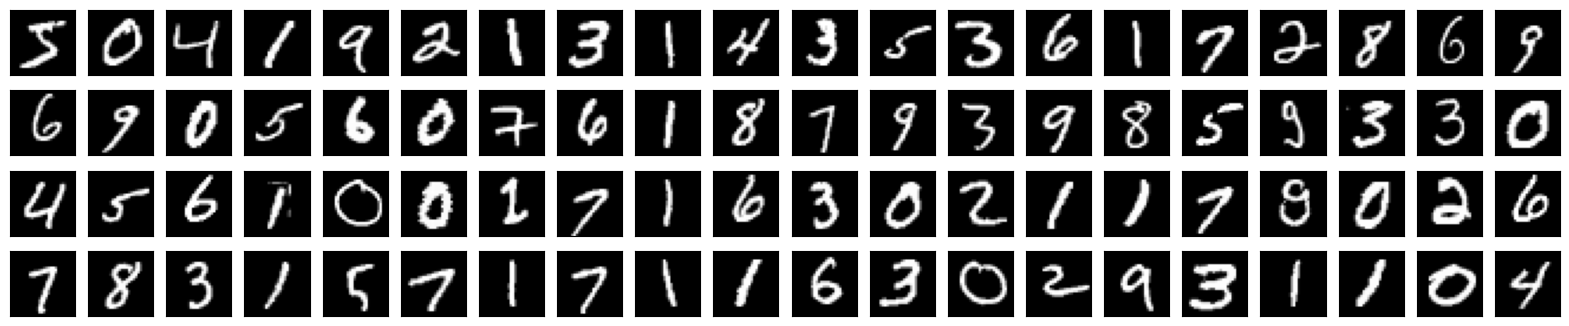

In [5]:
def fn():
    X,y = next(iter(train_dataloader))
    print(X.shape)
    print(X.min(),X.max()) # so it is normalize
    print(y.shape)
    X = X.squeeze().view(4,-1,28,28)
    visualize_rows(*X)
fn()

### Model

In [6]:
class MNIST_Decoder(nn.Module):
    def __init__(self,input_size,ngf=64,channel_num=1) -> None:
        super(MNIST_Decoder,self).__init__()
        self.latent_dim = input_size
        # number of generator filters
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Dropout(),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout(),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout(),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Dropout(),
            
            nn.ConvTranspose2d(ngf,channel_num, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh(),
        )
    
    def forward(self,x):
        x = x.view(x.size(0),-1,1,1)
        x = x*0.5 + 0.5 # rescaling
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, encoder,decoder) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def encode(self,x):
        return self.encoder(x)
    def decode(self,x):
        return self.decoder(x)
    def forward(self,x):
        x = self.encode(x)
        x = self.decode(x)
        return x


In [7]:
def generate(G,y):
    batch_sz = y.size(0)
    noise = torch.randn((batch_sz,G.latent_dim),device=device)
    noise[:,0] = y # conditioning
    return G(noise)

def generator_pretrain_pass(G,real_X,real_y,criterion):
    fake_X = generate(G,real_y)
    loss = criterion(fake_X.flatten(1),real_X.flatten(1))
    return loss

def generate_n_plot(G:MNIST_Decoder,y=None):
    with torch.no_grad():
        G.eval()
        if y is None:
            y = torch.randint(0,10,(16,),device=device)
        fake_X = generate(G,y)
        fake_X = fake_X.view(fake_X.size(0),28,28).cpu()
        fake_X = fake_X.view(2,-1,28,28)
        visualize_rows(*fake_X,n=10)

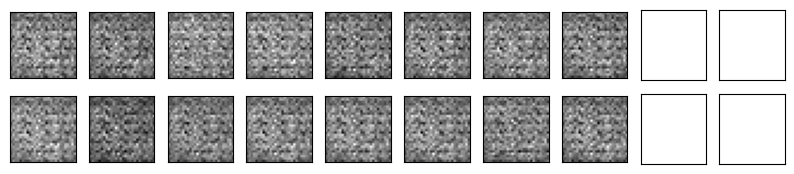

tensor(-0., device='cuda:0')

In [8]:
generator = MNIST_Decoder(10).to(device)

generate_n_plot(generator)
X,y = next(iter(train_dataloader))
X,y = X.to(device),y.to(device)
criterion = nn.CrossEntropyLoss()
generator_pretrain_pass(generator,X,y,criterion)
criterion(X,X)

### Optimization

In [9]:
def load(ctor,model_checkpoint_pth):
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    generator = ctor(**checkpoint['generator kwargs']).to(device)
    generator.load_state_dict(checkpoint['generator'])
    
    optimizer = torch.optim.Adam(generator.parameters(), lr=checkpoint['max_lr'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return generator,optimizer,checkpoint['train_loss_hist'],checkpoint['test_loss_hist']

def save_checkpoint(generator,optimizer,
                    train_loss_hist,test_loss_hist,
                    model_checkpoint_pth):
    checkpoint = torch.load(model_checkpoint_pth,map_location=device)
    new_checkpoint_values = {
        'generator'         : generator.state_dict(),
        'optimizer'         : optimizer.state_dict(),
        'train_loss_hist'   : train_loss_hist,
        'test_loss_hist'    : test_loss_hist,
    }
    for k,v in new_checkpoint_values.items():
        checkpoint[k] = v
    torch.save(checkpoint,model_checkpoint_pth)

In [10]:
model_checkpoint_pth = 'model_checkpoint/mnist_generator_only.pth'
criterion = nn.CrossEntropyLoss()
force_init = False
import os
if not os.path.exists(model_checkpoint_pth) or force_init:
    kwargs_ctor = {'input_size':2}
    generator = MNIST_Decoder(**kwargs_ctor).to(device)
    max_lr = 0.1
    optimizer = torch.optim.Adam(generator.parameters(), lr=max_lr)
    torch.save({
        'generator kwargs' :kwargs_ctor,
        'max_lr' : max_lr,
        'optimizer' : optimizer.state_dict(),
        'generator' : generator.state_dict(),
        'train_loss_hist' : [],
        'test_loss_hist' : [],
    },model_checkpoint_pth)

generator,optimizer,train_loss_hist,test_loss_hist = load(MNIST_Decoder,model_checkpoint_pth)
save_checkpoint(generator,optimizer,
                    train_loss_hist,test_loss_hist,
                    model_checkpoint_pth)

### Training

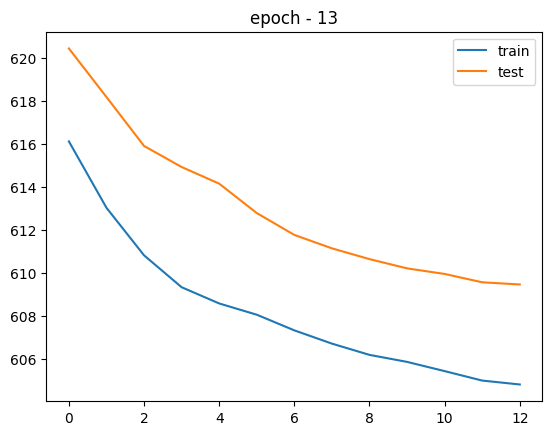

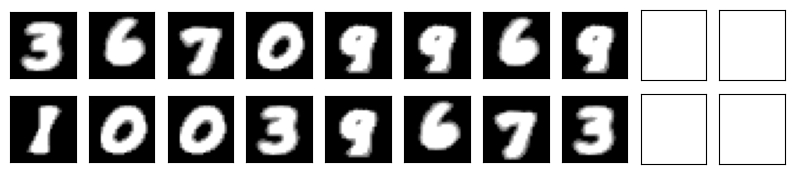

In [11]:
def train_generator(G,dataset,optimizer,criterion):
    losses = []
    G.train()
    for real_X,real_y in dataset:
        real_X,real_y = real_X.to(device),real_y.to(device)
        
        G.zero_grad()
        loss = generator_pretrain_pass(G,real_X,real_y,criterion)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return sum(losses)/len(losses)

def test_generator(G,dataset,criterion):
    losses = []
    G.eval()
    for real_X,real_y in dataset:
        real_X,real_y = real_X.to(device),real_y.to(device)
        loss = generator_pretrain_pass(G,real_X,real_y,criterion)
        losses.append(loss.item())
    return sum(losses)/len(losses)

def train(epochs_num = 1):
    from IPython import display
    for _ in range(epochs_num):
        loss = train_generator(generator,train_dataloader,optimizer,criterion)
        train_loss_hist.append(loss)
        loss = test_generator(generator,test_dataloader,criterion)
        test_loss_hist.append(loss)
        
        save_checkpoint(generator,optimizer,train_loss_hist,test_loss_hist,model_checkpoint_pth)
        
        
        display.clear_output()
        plt.title(f"epoch - {len(train_loss_hist)}")
        plt.plot(train_loss_hist,label='train')
        plt.plot(test_loss_hist,label='test')
        plt.legend()
        generate_n_plot(generator)
        plt.show()

train(3)

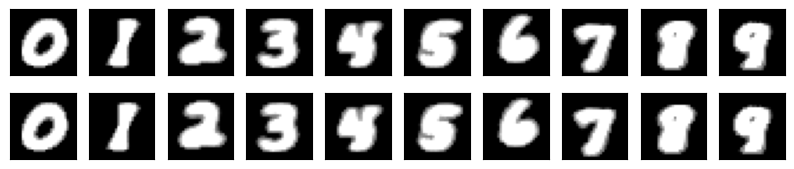

In [12]:
generator,*_ = load(MNIST_Decoder,model_checkpoint_pth)

generate_n_plot(generator,
                torch.tensor(list(range(10))*2))

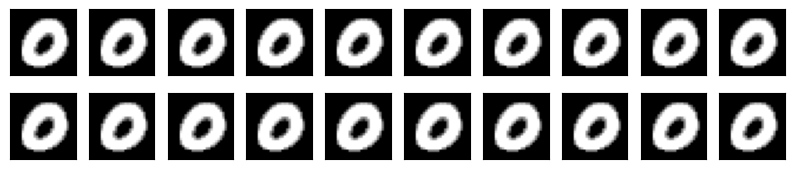

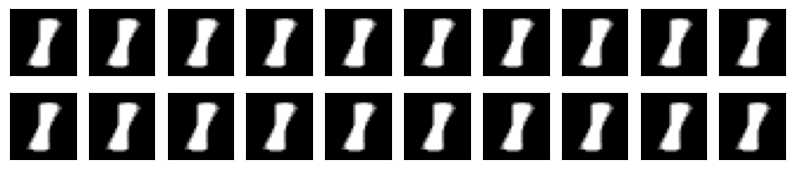

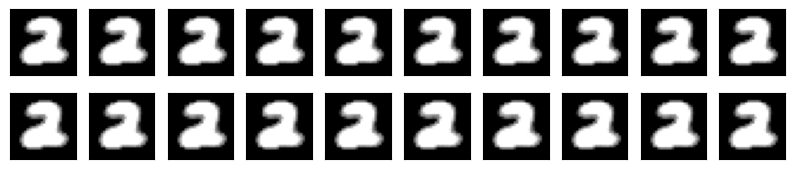

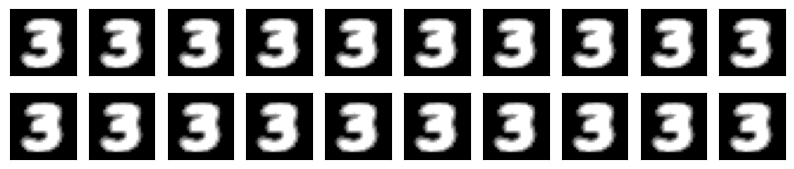

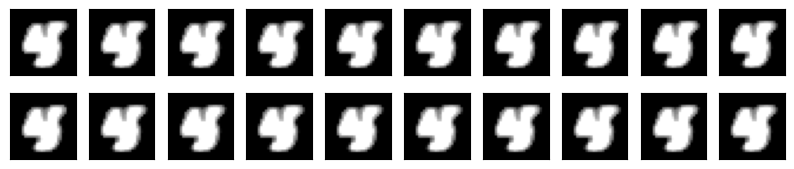

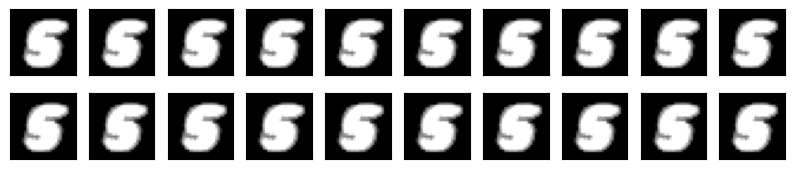

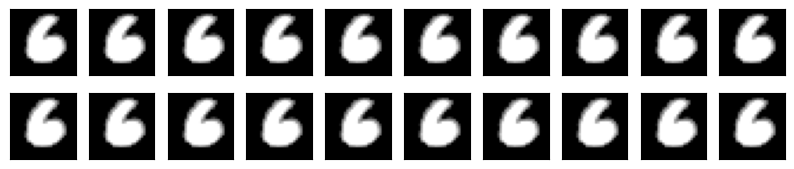

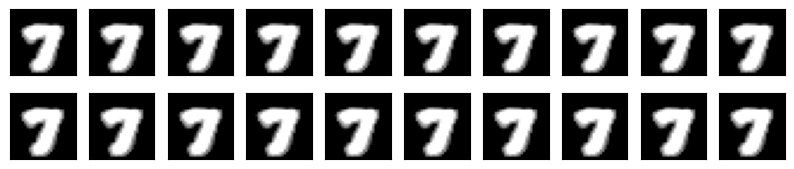

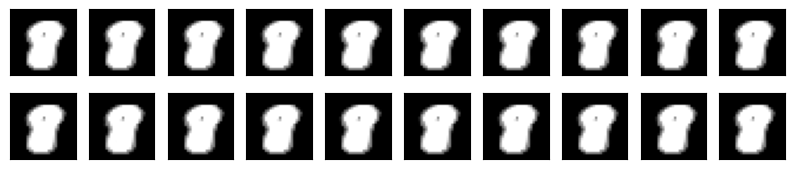

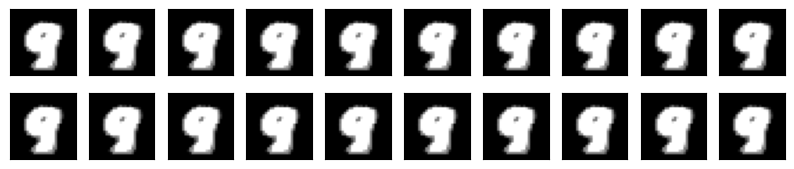

In [13]:
for i in range(10):
    generate_n_plot(generator,torch.ones(20)*i)